In [ ]:
### Intro to AI Group 3 Final Project - Using CV to Predict Ocular Disease

In [22]:
import keras
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet',
                   input_shape=(224, 224, 3),
                   include_top=False)
base_model.trainable = False

In [25]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x - keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(8)(x)
model = keras.Model(inputs, outputs)

In [26]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[keras.metrics.SparseCategoricalAccuracy()])

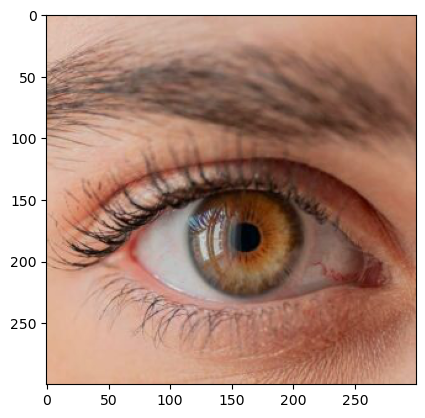

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

show_image('C:\\Users\\elanw\\OneDrive\\Pictures\\eye_square.jpg')
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)


In [7]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_process_image(image_path):
    img = image_utils.load_img(image_path, target_size=(224,224))
    img = image_utils.img_to_array(img)
    img = img.reshape(1,224,224,3)
    img = preprocess_input(img)
    return img

In [8]:
from tensorflow.keras.applications.vgg16 import decode_predictions

def readable_predictions(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    predictions = model.predict(image)
    print('Predicted:', decode_predictions(predictions, top=3)[0])

1/1 [==============================] - 0s 146ms/step
Predicted: [('n01910747', 'jellyfish', 0.38048986), ('n03637318', 'lampshade', 0.31530604), ('n02782093', 'balloon', 0.0752076)]


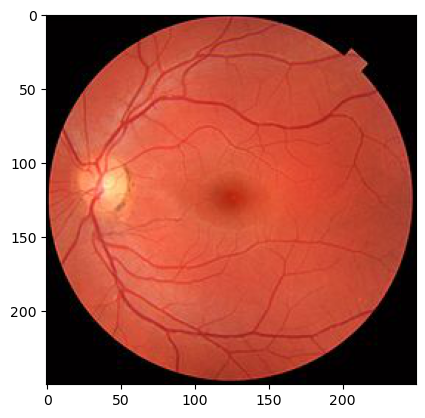

In [18]:
readable_predictions('C:/Users/elanw/OneDrive/Pictures/fundus.jpg')